In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
test=pd.read_csv('./test.csv')
#train=pd.read_csv('./train.csv')
#dev=pd.read_csv('./dev.csv')

In [3]:
len(train),len(test),len(dev)

(1749157, 257186, 216030)

In [3]:
test['rating'].head()

0    4.0
1    3.0
2    5.0
3    5.0
4    4.0
Name: rating, dtype: float64

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257186 entries, 0 to 257185
Data columns (total 28 columns):
Unnamed: 0                      257186 non-null int64
Unnamed: 0.1                    257186 non-null int64
Unnamed: 0.1.1                  257186 non-null int64
author                          257186 non-null object
hotel_url                       257186 non-null object
property_dict                   257186 non-null object
rating                          257186 non-null float64
text                            257186 non-null object
timeStruct                      257186 non-null object
timeUnix                        257186 non-null int64
service                         257186 non-null float64
cleanliness                     257186 non-null float64
rooms                           257186 non-null float64
value                           257186 non-null float64
location                        257186 non-null float64
bin_service                     257186 non-null float64
bin_cl

# Mask
Five aspect:

0.service                         
1.cleanliness                                                
2.value                           
3.location  
4.room



 0-4 in this order

Service   Cleanliness Value  Location Room 

In [8]:
import ast

In [11]:
test['text_filtered_per_sentence'][1]

'["unfortunately the accommodation does n\'t come up to standard !", \'the free shuttle from the airport is great , which s the main reason we chose the avra and rafina .\', \'there is really no other competition in rafina as far as hotel accommodation is concerned-\', "there \'s a few places with rooms , and some studios", \'the hotel is a bit run down , but is due for a makeover soon , which will make it a fantastic place to stay with its proximity to the port and many good restaurants nearby .\', "if you do n\'t mind a few frayed carpets and a knocked about room you wo n\'t have any complaints ."]'

In [12]:
test['text'][1]

"Unfortunately the accommodation doesn't come up to standard! The free shuttle from the airport is great, which s the main reason we chose The Avra and Rafina. There is really no other competition in Rafina as far as hotel accommodation is concerned- there's a few places with rooms, and some studios but that's about it. The hotel is a bit run down, but is due for a makeover soon, which will make it a fantastic place to stay with its proximity to the port and many good restaurants nearby. If you don't mind a few frayed carpets and a knocked about room you won't have any complaints."

In [9]:
test['text_filtered_per_sentence'].apply(ast.literal_eval).apply(len)

0         3
1         6
2         6
3         7
4         5
         ..
257181    4
257182    3
257183    4
257184    5
257185    4
Name: text_filtered_per_sentence, Length: 257186, dtype: int64

In [10]:
test['aspect_filtered_per_sentence']

0                     [4, 3, 3]
1            [1, 3, 3, 2, 3, 1]
2            [4, 3, 4, 0, 0, 3]
3         [1, 4, 0, 3, 3, 3, 0]
4               [2, 1, 4, 3, 3]
                  ...          
257181             [3, 4, 0, 0]
257182                [3, 3, 3]
257183             [3, 3, 0, 2]
257184          [3, 0, 3, 3, 4]
257185             [4, 4, 0, 4]
Name: aspect_filtered_per_sentence, Length: 257186, dtype: object

In [13]:
test['text_filtered_per_relation'][1]

"['the free shuttle from the airport', 'the free shuttle from the airport great', 'no other competition in rafina', 'a few places with rooms', 'it a fantastic place to stay with its proximity to the port and many good restaurants nearby', 'its proximity to the port and many good restaurants nearby', 'many good restaurants nearby', 'a few frayed carpets and a knocked about room']"

In [14]:
test['text'][1]

"Unfortunately the accommodation doesn't come up to standard! The free shuttle from the airport is great, which s the main reason we chose The Avra and Rafina. There is really no other competition in Rafina as far as hotel accommodation is concerned- there's a few places with rooms, and some studios but that's about it. The hotel is a bit run down, but is due for a makeover soon, which will make it a fantastic place to stay with its proximity to the port and many good restaurants nearby. If you don't mind a few frayed carpets and a knocked about room you won't have any complaints."

In [17]:
test['aspect_filtered_per_relation'][1]

'[3, 3, 3, 2, 3, 3, 3, 1]'

In [11]:
test['rel_filtered_per_relation']

0         ['15 minute walk  -(to)-> top', 'many choices ...
1         ['free shuttle  -(from)-> airport', 'great  -(...
2         ['lovely  -(amod)-> place', 'lovely  -(acomp-n...
3         ['very comfortable  -(acomp-nsubj)-> room', 'l...
4         ['good  -(amod)-> rate', 'clean  -(acomp-nsubj...
                                ...                        
257181    ['excellent  -(acomp-nsubj)-> breakfast', 'exc...
257182    ['excellent  -(amod)-> hotel', 'great  -(amod)...
257183    ['great  -(amod)-> place', 'next stay  -(in)->...
257184    ['nice  -(amod)-> lobby', 'nice  -(amod)-> sta...
257185    ['great  -(amod)-> place', 'large  -(amod)-> c...
Name: rel_filtered_per_relation, Length: 257186, dtype: object

### Relation between original aspect and filtered aspect 

In [25]:
#original aspect
original_aspect=test['aspect_filtered_per_sentence'].apply(ast.literal_eval).apply(set)


In [22]:
#filtered aspect
filtered_aspect=test['aspect_filtered_per_relation'].apply(ast.literal_eval).apply(set)




In [32]:
equal_proportion=sum(filtered_aspect==original_aspect)/len(filtered_aspect )
print('Percentage of equal coverage of aspects={}'.format(equal_proportion))

Percentage of equal coverage of aspects=0.34886813434634856


In [35]:
equal_proportion=sum(filtered_aspect.apply(len)>original_aspect.apply(len))/len(filtered_aspect )
print('filtered cover more than original aspects={}'.format(equal_proportion))

filtered cover more than original aspects=0.31661132410006765


In [36]:
equal_proportion=sum(filtered_aspect.apply(len)<original_aspect.apply(len))/len(filtered_aspect )
print('Original cover more than filtered aspects={}'.format(equal_proportion))

Original cover more than filtered aspects=0.23458508627996857


### to_json(filtered by relation)

In [55]:
test_filtered=test.copy()
test_filtered['text_filtered_per_relation_grouped']=test['text_filtered_per_relation'].apply(ast.literal_eval).\
apply(lambda x:"\\".join(x) )





In [ ]:
tot=pd.concat([dev,test,train])
df=tot.sort_values('hotel_url')[['hotel_url','text_filtered_per_relation_grouped','rating']]
df.to_json('../review_filtered.json',orient='records')

## check data

In [5]:
test.head(3)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,author,hotel_url,property_dict,rating,text,timeStruct,timeUnix,...,bin_value,bin_location,bin_rating,text_filtered_per_sentence,aspect_filtered_per_sentence,text_filtered_per_relation,aspect_filtered_per_relation,rel_filtered_per_relation,set_kw,id
0,2017872,43714034,43714034,Azurian,Hotel_Review-g552009-d11668074-Reviews-Premier...,"{'cleanliness': 4.0, 'service': 4.0, 'value': ...",4.0,"Clean, cheap if you book 10 days in advance an...",2018-08-01 00:00:00,1533074400,...,1.0,-1.0,0.0,"['clean , cheap if you book 10 days in advance...","[4, 3, 3]",['only a 15 minute walk to the top of the town...,"[3, 0, 3, 3, 3]","['15 minute walk -(to)-> top', 'many choices ...","{480, 896, 903, 176, 848}",2017872
1,1502188,28885530,28885530,Azurian,Hotel_Review-g1234491-d289570-Reviews-Hotel_Av...,"{'sleep quality': 3.0, 'service': 4.0, 'value'...",3.0,Unfortunately the accommodation doesn't come u...,2018-09-01 00:00:00,1535752800,...,0.0,-1.0,0.0,"[""unfortunately the accommodation does n't com...","[1, 3, 3, 2, 3, 1]","['the free shuttle from the airport', 'the fre...","[3, 3, 3, 2, 3, 3, 3, 1]","['free shuttle -(from)-> airport', 'great -(...","{768, 960, 176, 785, 272, 784, 180}",1502188
2,1527639,29827675,29827675,Azurian,Hotel_Review-g295415-d2044185-Reviews-Villa_Na...,"{'rooms': 5.0, 'cleanliness': 5.0, 'service': ...",5.0,We stayed for 4 nights but really should have ...,2018-01-01 00:00:00,1514761200,...,-1.0,-1.0,1.0,['villa nagara is a lovely place to stay and c...,"[4, 3, 4, 0, 0, 3]","['a lovely place to stay and chill', 'our room...","[3, 4, 4, 0, 0, 3, 3]","['lovely -(amod)-> place', 'lovely -(acomp-n...","{0, 768, 1121, 1120, 960, 775, 973, 976, 977}",1527639


In [13]:
test.iloc[0,4]

'Hotel_Review-g552009-d11668074-Reviews-Premier_Inn_Monmouth_Hotel-Monmouth_Monmouthshire_South_Wales_Wales.html'

In [24]:
test.iloc[0,5]

"{'cleanliness': 4.0, 'service': 4.0, 'value': 5.0}"

In [26]:
test.iloc[0,7]

'Clean, cheap if you book 10 days in advance and comfortable. Only a 15 minute walk to the top of the town with many choices for breakfast and evening meals. A very good base for exploring he local area, with Ross on Wye, Hay on Wye and Brecon a short drive away. No omplaints!.'

In [35]:
test[['service','location','bin_service']]

,service,location,bin_service
0,4.0,-1.0,0.0
1,4.0,-1.0,0.0
2,5.0,-1.0,1.0
3,-1.0,5.0,-1.0
4,4.0,-1.0,0.0
...,...,...,...
257181,5.0,5.0,1.0
257182,5.0,5.0,1.0
257183,5.0,5.0,1.0
257184,5.0,5.0,1.0


In [48]:
test['service'].unique()

array([ 4.,  5., -1.,  3.,  2.,  1.])

In [49]:
test['bin_service'].unique()

array([ 0.,  1., -1.])

In [37]:
test['text_filtered_per_sentence'][0]

"['clean , cheap if you book 10 days in advance and comfortable .', 'only a 15 minute walk to the top of the town with many choices for breakfast and evening meals .', 'a very good base for exploring he local area , with ross on wye , hay on wye and brecon a short drive away .']"

In [38]:
test['text'][0]

'Clean, cheap if you book 10 days in advance and comfortable. Only a 15 minute walk to the top of the town with many choices for breakfast and evening meals. A very good base for exploring he local area, with Ross on Wye, Hay on Wye and Brecon a short drive away. No omplaints!.'

In [39]:
test['aspect_filtered_per_sentence'][0]

'[4, 3, 3]'

In [40]:
test['text_filtered_per_relation'][0]

"['only a 15 minute walk to the top of the town with many choices for breakfast and evening meals .', 'many choices for breakfast and evening meals', 'a very good base for exploring he local area , with ross on wye , hay on wye and brecon a short drive away .', 'ross on wye , hay on wye and brecon', 'hay on wye and brecon']"

In [41]:
test['aspect_filtered_per_relation'][0]

'[3, 0, 3, 3, 3]'

In [42]:
test['rel_filtered_per_relation'][0]

"['15 minute walk  -(to)-> top', 'many choices  -(for)-> breakfast meals', 'very good  -(amod)-> base', 'ross  -(on)-> brecon', 'hay  -(on)-> wye']"

## data visualization

In [35]:
# check the number of business 

def check_business_no(data):
    return len(set(data['hotel_url']))

check_business_no(train),check_business_no(test),check_business_no(dev)

(38897, 37538, 36681)

In [43]:
train['text'].apply(len).sort_values()

1540616        9
588528        14
1579838       16
1646008       17
588531        19
           ...  
972406     32683
1118628    35119
509202     40224
509208     58889
509206     63343
Name: text, Length: 1749157, dtype: int64

__Distribution of review lenth:__  ⬇️

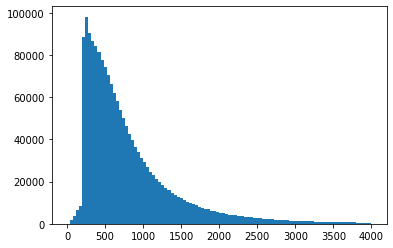

In [55]:

plt.hist(train['text'].apply(len),bins=100,range=(0,4000));

__Distribution of number of reviews associated to hotel:__  ⬇️

In [61]:
n_review_to_hotel=train.groupby('hotel_url')['text'].apply(list).apply(len)

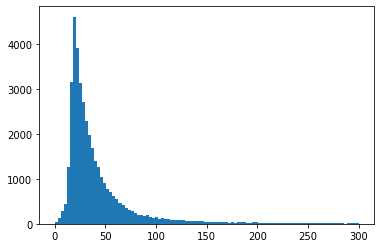

In [65]:
plt.hist(n_review_to_hotel,bins=100,range=(0,300));

## to_json

In [5]:
tot=pd.concat([dev,test,train])

In [ ]:
df=tot.sort_values('hotel_url')[['hotel_url','text','rating']]

In [ ]:
df.to_json('../review1.json',orient='records')

## subword encoder

In [8]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [9]:
# Build
encoder = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    df['text'].to_list(), target_vocab_size=32000)

In [10]:
import pickle
with open('../processed/subwordenc_32000_secondpass.pkl', 'wb') as file:
    pickle.dump(encoder, file, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
encoder.encode('hhhhhdsfhladfhklsahhh')

[22022, 19355, 7888, 31880, 10213, 7054, 31880, 17395, 6183, 6904, 19355]